In [1]:
# ### mount on google drive if you running the code on colab
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [2]:
import os
os.chdir('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.acc_pixel import acc_matrix
from watnet_infer import watnet_infer


In [6]:
## test image and test sample
path_S2_img = 'data/test-demo/T49QGF_20191017_6Bands_Urban_Subs.tif'
# pre-trained model
path_model = 'model/pretrained/watnet.h5'
path_result_map = 'data/test-demo/result_water_map.tif'
## super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


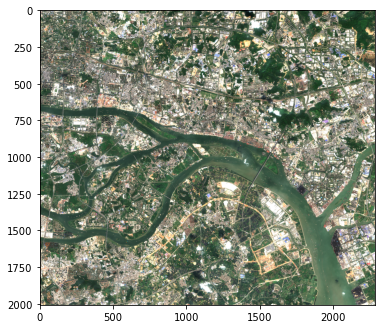

In [7]:
# -----Load and prepare the satellite image data -----#
sen2_img, img_info = readTiff(path_in=path_S2_img)
sen2_img = np.float32(np.clip(sen2_img/10000, a_min=0, a_max=1))  ## normalization
plt.figure(figsize=(6,6))
plt.imshow(sen2_img[:, :, (2,1,0)]*5)


In [10]:
### ---- surface water mapping by using pretrained watnet.
water_map = watnet_infer(rsimg=sen2_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


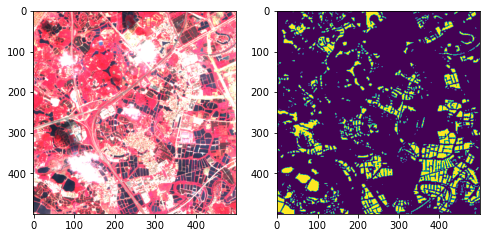

In [11]:
### show the result
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sen2_img[1500:2000, 1000:1500, (3,2,1)]*6.5)
plt.subplot(1,2,2)
plt.imshow(water_map[1500:2000, 1000:1500, 0])


OA: 1.0
Producer acc: 1.0
user acc: 1.0
Confusion matrix: [[259   0]
 [  0 234]]


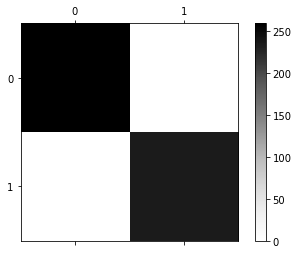

In [18]:
## show the accuracy
path_sam = 'data/test-data(demo)/val_sam.csv'
df_sam = pd.read_csv(path_sam, header=0)
acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(water_map, df_sam.to_numpy(), id_label=1)
print('OA:', acc_oa)
print('Producer acc:', acc_prod)
print('user acc:', acc_user)
print('Confusion matrix:', np.around(confus_mat,4))
plt.matshow(confus_mat,cmap=plt.cm.Greys, fignum=0)
plt.colorbar()


### Save the result.

In [19]:
img_info

{'geoextent': (738710.0, 761530.0, 2544530.0, 2564600.0),
 'geotrans': (738710.0, 10.0, 0.0, 2564600.0, 0.0, -10.0),
 'geosrs': '32649',
 'row': 2007,
 'col': 2282,
 'bands': 6}

In [20]:
# # # save the result
# writeTiff(im_data = water_map.astype(np.int8), 
#           im_geotrans = img_info['geotrans'], 
#           im_geosrs = img_info['geosrs'], 
#           path_out = path_result_map)
